# Simple Example: UQ Study with OpenUQFOAM

This notebook demonstrates basic usage of the OpenUQFOAM framework using an official example from the OpenFOAM documentation: the unsteady transport equation of a passive scalar inside the `pitzDaily` geometry with a known velocity field.

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Import OpenUQFOAM modules
from uq_runner import run_simulation, generate_samples, run_uq_study
from openfoam_tools import load_config, parse_openfoam_case, read_uq_experiment

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## 1. Example of single realization

In [2]:
experiment_config = {
    'solver': 'Allrun',
    'experiment': {
        'name': 'singleRealization',
        'base_case_dir': "../templates/scalarTransportFoam"
    },
}

Run a single simulation

In [3]:
run_simulation(params={'constant__transportProperties__DT': 0.01}, exp_config=experiment_config, verbose=False)

Read the OpenFOAM results

In [4]:
data_single = parse_openfoam_case(
    case_dir="../experiments/singleRealization",
    variables=["U", "T"],
    time_dirs=[f"{i:g}" for i in np.arange(0, 0.1 + 1e-6, 0.005)]
)
data_single

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 21, cell: 12225, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.005 0.01 0.015 ... 0.085 0.09 0.095 0.1
    x        (cell) float64 98kB -0.01981 -0.01826 -0.01677 ... 0.2824 0.2874
    y        (cell) float64 98kB 0.0001594 0.0001594 ... 0.01731 0.01678
    z        (cell) float64 98kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: cell, component
Data variables:
    U        (time, cell, component) float64 6MB 9.857 -0.8864 ... -0.3668 0.0
    T        (time, cell) float64 2MB 0.0 0.0 0.0 0.0 ... 0.9355 0.9304 0.9337

In [5]:
from fluidfoam import readmesh, readvector, readscalar, readfield, typefield

auxcase = "../experiments/myFirstUQStudy"
# auxcase = "../experiments/myFirstSurrogate"


variable = "T"

x, y, z = readmesh(auxcase + "/sample_000", verbose=False)
aux = readfield(auxcase + "/sample_000", "0", variable, verbose=False)
# auxtype = typefield(auxcase + "/sample_000", "0", variable)

# if aux.ndim == 1 and aux.shape[0] == 1:
#     print("entrei")
#     aux = np.stack([aux] * len(x), axis=0).flatten()
# elif aux.ndim == 2 and aux.shape[1] == 1:
#     print("entrei")
#     aux = np.stack([aux.T[0]] * len(x), axis=0).reshape(-1, len(x))
# try:
aux.T

array([0.])

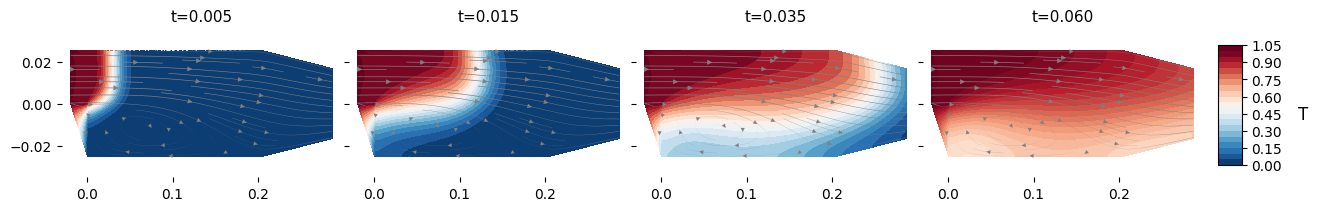

In [6]:
times = [0.005, 0.015, 0.035, 0.06]
time_indices = [data_single.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(1, len(times), figsize=(12, 2), sharex=True, sharey=True, constrained_layout=True)

for i, tidx in enumerate(time_indices):
    temp = data_single['T'].isel(time=tidx).values
    
    x = data_single.x.values
    y = data_single.y.values
    
    cs = axs[i].tricontourf(x, y, temp, cmap='RdBu_r', levels=20, vmin=0, vmax=1)
    
    vel = data_single['U'].isel(time=tidx).values
    ux_orig = vel[:, 0]
    uy_orig = vel[:, 1]

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
    uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')

    uxi = np.nan_to_num(uxi)
    uyi = np.nan_to_num(uyi)
    
    ut_grid = np.sqrt(uxi**2 + uyi**2)

    lw = ut_grid / 20
    axs[i].streamplot(xi, yi, uxi, uyi, density=0.6, color='gray', linewidth=lw, arrowsize=0.7)
    
    for spine in axs[i].spines.values():
        spine.set_visible(False)
    
    axs[i].set_xlim([x.min()-0.01, x.max()+0.01])
    axs[i].set_ylim([y.min()-0.01, y.max()+0.01])
    
    axs[i].set_title(f't={times[i]:.3f}', fontsize=11)

cs = axs[0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.2, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('T', rotation=0, labelpad=15, fontsize=12)

plt.show()

## 2. Load configuration

In [7]:
config = load_config("config_01.yml")
param_ranges = config['parameter_ranges']

print("Parameter ranges:")
for param, range_vals in param_ranges.items():
    print(f"  {param}: {range_vals}")

Parameter ranges:
  constant__transportProperties__DT: [0.01, 0.3]


## 3. Generate parameter samples

In [8]:
n_samples = 10

X = generate_samples(
    n_samples=n_samples,
    param_ranges=param_ranges,
    method='lhs',
    seed=42
)

print(f"Generated samples shape: {X.shape}")
X

Generated samples shape: (10, 1)


array([[0.1985],
       [0.2855],
       [0.2565],
       [0.0245],
       [0.1405],
       [0.2275],
       [0.0825],
       [0.1695],
       [0.1115],
       [0.0535]])

## 4. Run UQ study

In this section we are going to run our first UQ study using the same simulation configuration as before. We will use the `run_uq_study` function to execute the study with the specified setup given by the configuration specified in the `config_01.yml`.

In [9]:
run_uq_study( config_file="config_01.yml", n_samples=10, verbose=False )

Running simulations: 100%|██████████| 10/10 [00:49<00:00,  4.95s/it]


In [10]:
n_samples=10
ds = read_uq_experiment(
    case_dir="../experiments/myFirstUQStudy",
    variables=["U", "T"],
    n_samples=n_samples,
    time_dirs=[f"{i:g}" for i in np.arange(0, 0.1 + 1e-6, 0.005)],
    nthreads=5
)
ds

Processing cases:   0%|          | 0/10 [00:00<?, ?case/s]

Processing cases: 100%|██████████| 10/10 [00:06<00:00,  1.51case/s]


<xarray.Dataset> Size: 82MB
Dimensions:  (sample: 10, time: 21, cell: 12225, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.005 0.01 0.015 ... 0.085 0.09 0.095 0.1
    x        (cell) float64 98kB -0.01981 -0.01826 -0.01677 ... 0.2824 0.2874
    y        (cell) float64 98kB 0.0001594 0.0001594 ... 0.01731 0.01678
    z        (cell) float64 98kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * sample   (sample) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: cell, component
Data variables:
    U        (sample, time, cell, component) float64 62MB 9.857 -0.8864 ... 0.0
    T        (sample, time, cell) float64 21MB 0.0 0.0 0.0 ... 0.9576 0.959

_Notice the sample coordinate characterizes multiple runs, like an additional dimension in the dataset._


### Evaluate Sampled Simulations

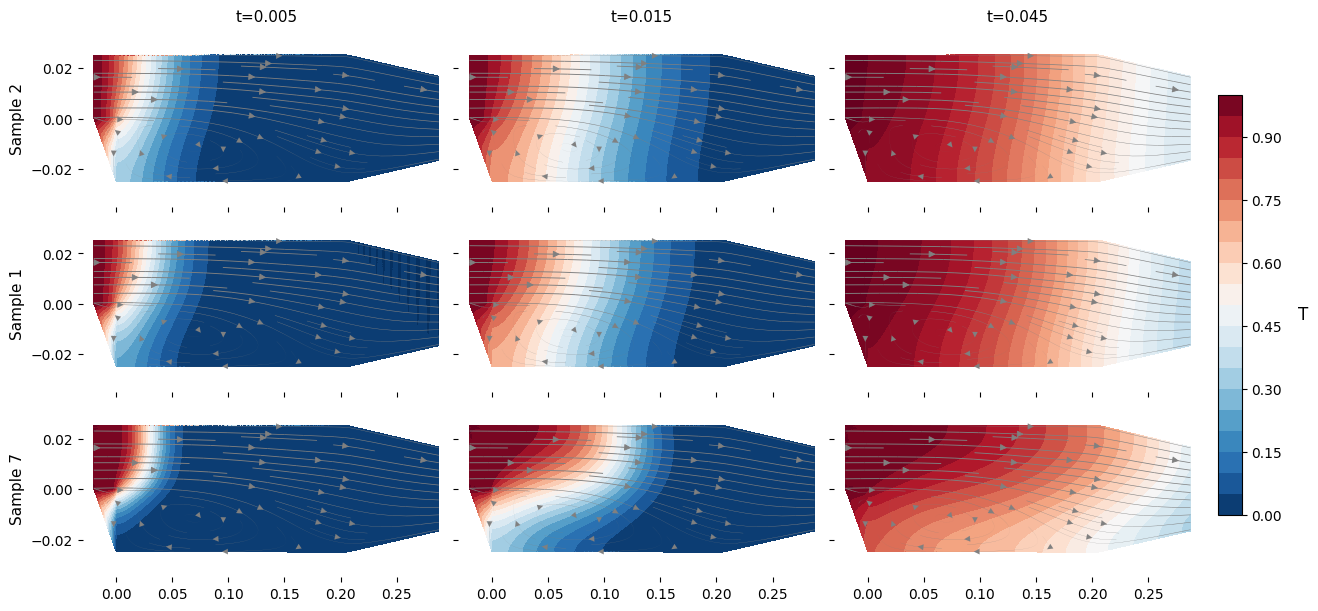

In [15]:
np.random.seed(39)
sample_indices = np.random.choice(n_samples, size=3, replace=False)

times = [0.005, 0.015, 0.045]
time_indices = [ds.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(len(sample_indices), len(times), figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)

for row, sample_idx in enumerate(sample_indices):
    for col, tidx in enumerate(time_indices):
        ax = axs[row, col]
        
        # Temperature field
        temp = ds['T'].isel(sample=sample_idx, time=tidx).values
        x = ds.x.values
        y = ds.y.values

        cs = ax.tricontourf(x, y, temp, cmap='RdBu_r', levels=20, vmin=0, vmax=1)

        # Velocity field
        vel = ds['U'].isel(sample=sample_idx, time=tidx).values
        ux_orig = vel[:, 0]
        uy_orig = vel[:, 1]
        
        xi = np.linspace(x.min(), x.max(), 100)
        yi = np.linspace(y.min(), y.max(), 100)
        X, Y = np.meshgrid(xi, yi)
        
        uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
        uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')
        
        uxi = np.nan_to_num(uxi)
        uyi = np.nan_to_num(uyi)
        
        ut_grid = np.sqrt(uxi**2 + uyi**2)
        lw = ut_grid / 15
        
        ax.streamplot(xi, yi, uxi, uyi, density=0.6, color='gray', linewidth=lw)
        
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        ax.set_xlim([x.min()-0.01, x.max()+0.01])
        ax.set_ylim([y.min()-0.01, y.max()+0.01])
        
        # Add time label (only on top row)
        if row == 0:
            ax.set_title(f't={times[col]:.3f}', fontsize=11)
        
        # Add sample label (only on leftmost column)
        if col == 0:
            ax.set_ylabel(f'Sample {sample_idx}', fontsize=11)

cs = axs[0,0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('T', rotation=0, labelpad=15, fontsize=12)

plt.show()

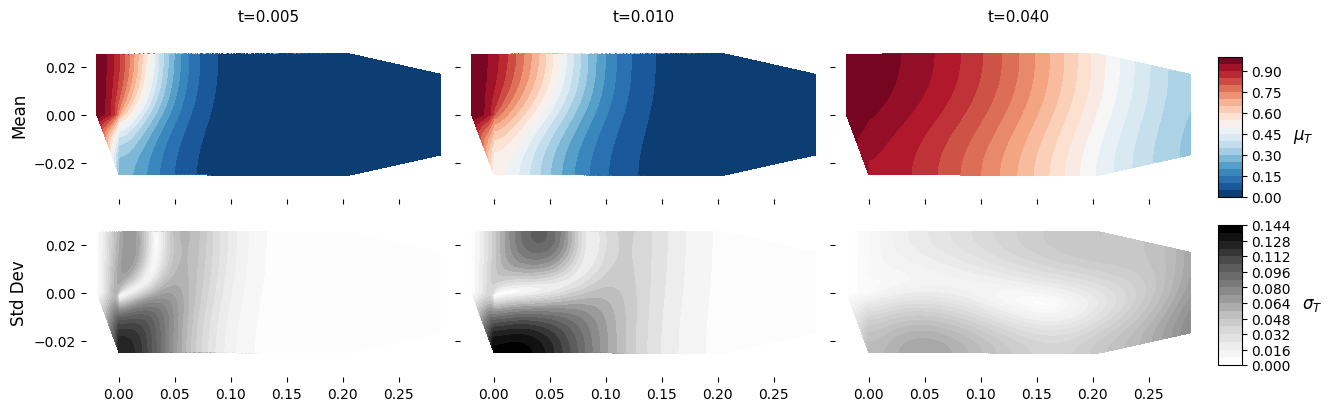

In [13]:
times = [0.005, 0.01, 0.04]
time_indices = [ds.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(2, len(times), figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)

x = ds.x.values
y = ds.y.values

# Calculate global min/max for consistent colorbars
T_mean_all = ds['T'].mean(dim='sample')
T_std_all = ds['T'].std(dim='sample')
mean_vmin, mean_vmax = T_mean_all.min().values, T_mean_all.max().values
std_vmin, std_vmax = 0, T_std_all.max().values

for col, tidx in enumerate(time_indices):
    # Mean plot
    ax_mean = axs[0, col]
    T_mean = ds['T'].isel(time=tidx).mean(dim='sample').values
    cs_mean = ax_mean.tricontourf(x, y, T_mean, cmap='RdBu_r', levels=20, 
                                   vmin=0, vmax=1)
    
    # Std deviation plot
    ax_std = axs[1, col]
    T_std = ds['T'].isel(time=tidx).std(dim='sample').values
    cs_std = ax_std.tricontourf(x, y, T_std, cmap='Grays', levels=20,
                                 vmin=0, vmax=std_vmax)
    
    for ax in [ax_mean, ax_std]:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xlim([x.min()-0.01, x.max()+0.01])
        ax.set_ylim([y.min()-0.01, y.max()+0.01])
    
    if col == 0:
        ax_mean.set_ylabel('Mean', fontsize=12)
        ax_std.set_ylabel('Std Dev', fontsize=12)
    
    ax_mean.set_title(f't={times[col]:.3f}', fontsize=11)

cs_mean = axs[0,0].collections[0]
cbar_ax_mean = fig.add_axes([1.01, 0.52, 0.02, 0.35])
cbar_mean = fig.colorbar(cs_mean, cax=cbar_ax_mean)
cbar_mean.set_label('$\\mu_T$', rotation=0, labelpad=15, fontsize=12)

cs_std = axs[1,1].collections[0]
cbar_ax_std = fig.add_axes([1.01, 0.1, 0.02, 0.35])
cbar_std = fig.colorbar(cs_std, cax=cbar_ax_std)
cbar_std.set_label('$\\sigma_T$', rotation=0, labelpad=15, fontsize=12)

plt.show()